<a href="https://colab.research.google.com/github/chenyq121/760-2022S2/blob/main/logR3optunaBaselineCNNTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.7 MB/s 
     |████████████████████████████████| 209 kB 79.8 MB/s 
     |████████████████████████████████| 81 kB 11.0 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 112 kB 63.2 MB/s 
     |████████████████████████████████| 147 kB 86.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a880cfd45f655b35fe30d787e44511b4b3530e89d0ede945106a762a029de828
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.0.0
    Uninstalling importlib-metadata-5.0.0:
      Successfully uninstalled importlib-metadata-5.0.0


In [ ]:
#mounted to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/Shareddrives/760/Data/')
os.getcwd()
os.listdir('.')

['image_Bored_Ape.zip',
 'Last_Sale_Price.csv',
 'price_cleaned.csv',
 'Bored_Ape_Dataset_Analysis.html',
 'ape',
 '1',
 '2',
 'temphold',
 'ape copy',
 'all_properties.csv',
 'test.txt',
 'validate.txt',
 'train.txt',
 'all_properties.gsheet',
 'price_cleaned_under200.csv',
 'u1.txt',
 'u2.txt',
 'test',
 'train',
 'u1',
 'u2',
 'utrain.txt',
 'uvalidate.txt',
 'utest.txt',
 'Trantimes.csv',
 'Tranaction.csv',
 'TransactionData.html',
 'price_cleaned_under200_log_label.numbers',
 'log-bin.gsheet',
 'log-bin.xlsx',
 'pricewlabel.csv',
 'cs760-model result track.xlsx',
 'grey',
 'to_archive_760project data pre-process.ipynb',
 'Copy of test (1).txt',
 'Copy of train (1).txt',
 'Copy of test.txt',
 'Copy of train.txt',
 'testopt.txt',
 'trainopt.txt',
 'ID-price-label.xlsx',
 'Copy of test.gdoc',
 'ID-price-label.gsheet',
 'Copy of ID-price-label.gsheet',
 'trainLinearAll.txt',
 'trainLinearCopy.gdoc',
 'trainLinearCopy.txt']

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import os
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold

import optuna

# data processing 
class ClassifyDataset(torch.utils.data.Dataset):
    def __init__(self,root_path,data_file,img_size=120):
        self.data_files=np.loadtxt(data_file,dtype=np.str, encoding='utf-8-sig')
        self.root_path=root_path
        self.class_list=os.listdir(
            os.path.join(root_path,'')
        )
        self.transforms=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size,img_size)), 
                torchvision.transforms.ToTensor()
            ]
        )
        glist = os.listdir(os.path.join(root_path, "ape/"))
        for i in range(len(self.data_files) - 1, -1, -1):
          if self.data_files[i].split('/')[-1] not in glist:
            self.data_files = np.delete(self.data_files, i)

    def __getitem__(self, item):
        data_file=self.data_files[item]
        #data_file=os.path.join(self.root_path,data_file)
        # get the image
        #img=Image.open(data_file).convert('RGB') # three channels
        # get the label(in this case the label is the folder name)
        tmp=data_file.split('/')
        label_name=float(tmp[-2])
        file_name = tmp[-1]
        data_file=os.path.join(self.root_path, "ape/", file_name)
        img=Image.open(data_file).convert('RGB')
        #print("label_name:",label_name)
        #label=self.class_list.index(label_name)
        #print("label:",label)
        # prepare the images and label
        img=self.transforms(img)
        label=torch.tensor(label_name, dtype=torch.float32)
        #print("torch_label:",label)
        return img,label


    def __len__(self):
        return len(self.data_files)



# model building
class CNet(nn.Module):
    def __init__(self,num_classes=21, n_layer = 1, kernel_size = 1):
        super(CNet,self).__init__()
        self.convList = nn.ModuleList()

        for i in range(1, n_layer):
          input = 2 ** (i + 3)
          output = 2 ** (i + 4)
          if i == 1:
            input = 3
            
          self.convList.append(
              nn.Sequential(
                #input, output, kernel size, step, padding
                nn.Conv2d(input, output, kernel_size, 1, padding=1),
                nn.BatchNorm2d(output), # batch normalization
                nn.ReLU()
              )
          )

        self.pool = nn.AvgPool2d(2, 2)
        self.fclayer=nn.Sequential(
                nn.Linear(2 * input, 2 * output),
                nn.ReLU(),
                nn.Linear(2 * output, num_classes)
        )
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))
        self.final_pool=nn.AdaptiveAvgPool1d(1)
        #self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
      x = self.convList[0](x)
      x = self.pool(x)
      for conv in self.convList[1:]:
        x = conv(x)
        x = self.pool(x)
      x = self.avg_pool(x)
      x = torch.flatten(x,1)
      #logits=self.fclayer(x)
      #prob=self.softmax(logits)
      x = self.fclayer(x)
      logits = self.final_pool(x)

      return logits

    


# training
def training(model, train_loader, len_train, batch_size,lr, epoch_num):
    # get training data
    #train_dataset=ClassifyDataset(root_path,train_data_file)
    #train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=0)


    # loss function and optimizer
    criterion=nn.MSELoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=lr)

    total_loss=[]

    for epoch in range(epoch_num):
        print(epoch+1,"epoch:")
        total_train_loss=0
        res_num=len_train
        for data in train_loader:

            if (res_num - batch_size) > 0:
                cnt=batch_size
                res_num = res_num - batch_size
            else:
                cnt=res_num
                res_num = 0

            ## GPU
            train_img,train_label=data
            train_img=train_img.to(device)
            train_label=train_label.to(device)

            ## get loss result
            train_logits=model(train_img)
            train_loss=criterion.forward(train_logits,train_label)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            #train_pred=torch.argmax(train_prob,dim=1)
            #train_acc=(train_pred==train_label).float()
            #train_acc=torch.mean(train_acc)
            # print('loss:',train_loss.item(), 'acc:', train_acc.item())
            total_train_loss=total_train_loss+train_loss*cnt

        total_train_loss=total_train_loss/len_train
        total_loss.append(total_train_loss.item())

    state_dict=model.state_dict()
    torch.save(state_dict,'/content/drive/Shareddrives/760/model/60-20-20model_20_epoch_120_lr0.01-optune_test.pth')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(total_loss)
    plt.legend(['train loss'])
    plt.show()

# test
def test(model, valid_loader, len_test):
    state_dict = torch.load('/content/drive/Shareddrives/760/model/60-20-20model_20_epoch_120_lr0.01-optune_test.pth')
    model.load_state_dict(state_dict)
    model.eval() # no BatchNormalization and Dropout

    #test_dataset=ClassifyDataset(root_path,test_data_file)
    #test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

    criterion = nn.MSELoss()

    res_num=len_test
    total_loss=[]

    for data in valid_loader:
      with torch.no_grad():

        if (res_num-batch_size)>0:
            cnt=batch_size
            res_num = res_num - batch_size
        else:
            cnt=res_num
            res_num = 0

        test_img,test_label=data
        test_img=test_img.to(device)
        test_label=test_label.to(device)

        test_logits=model(test_img)
        test_loss=criterion.forward(test_logits,test_label)

        total_loss.append(test_loss)

        # Top1 accuracy: correct number/total number
        #test_pred = torch.argmax(test_prob, dim=1)
        # print(test_pred)
        # print(test_label)
        #test_acc = (test_pred == test_label).float()
        # print(test_acc)
        #test_acc = torch.mean(test_acc)
        #total_acc = total_acc + test_acc * cnt

        # print('loss:',test_loss.item(), 'top1:',test_acc.item() )

    #total_acc=total_acc/len_test
    #return total_acc.item()

    avg_loss = sum(total_loss)/len_test
    return avg_loss.cpu()

    # print('\n')
    # print('Top-1 Accuracy:',total_acc.item())


def objective(trial, train_loader, valid_loader, len_train, len_test):

    params = {
              'n_layer': trial.suggest_categorical('n_layer', [5]),
              'kernel_size': trial.suggest_categorical('kernel_size', [5]),
              'lr': trial.suggest_categorical('lr', [0.01, 0.1]),#trial.suggest_float('lr', 0.01, 0.1, step = {0.04, 0.05}),
              'epoch_num': trial.suggest_categorical('epoch_num', [50])
              }

    # get model and put model on the device
    model=CNet(n_layer = params['n_layer'], kernel_size = params['kernel_size'])
    model = model.to(device)

    training(model, train_loader, len_train, batch_size,lr = params['lr'], epoch_num = params['epoch_num'])
    # torch.cuda.empty_cache()
    return test(model, valid_loader, len_test)

def objective_cv(trial):

    # get training data
    dataset=ClassifyDataset(root_path,train_data_file)

    fold = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(dataset)))):
        train_data = torch.utils.data.Subset(dataset, train_idx)
        valid_data = torch.utils.data.Subset(dataset, valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size,
            shuffle=True,
            num_workers=0
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size,
            shuffle=True,
            num_workers=0
        )
        accuracy = objective(trial, train_loader, valid_loader, len(train_data), len(valid_data))
        scores.append(accuracy)
    print(scores)
    print(np.std(scores))
    return np.mean(scores)





[I 2022-10-18 05:19:04,553] A new study created in memory with name: no-name-529c3cae-1573-4792-9526-b81f2ae48400
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1 epoch:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


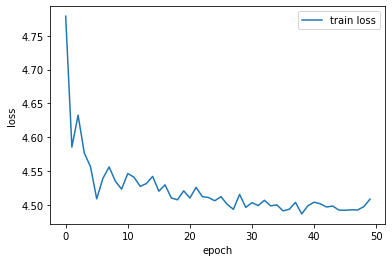

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


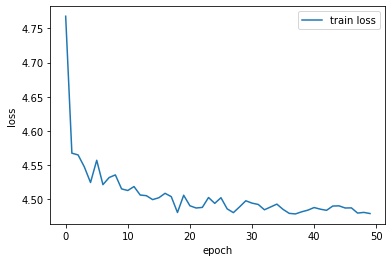

1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


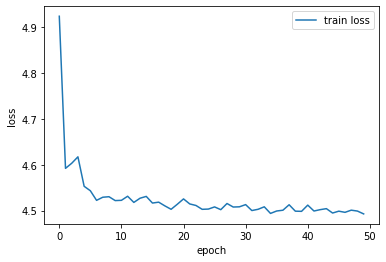

1 epoch:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


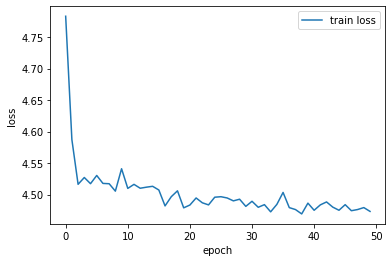

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


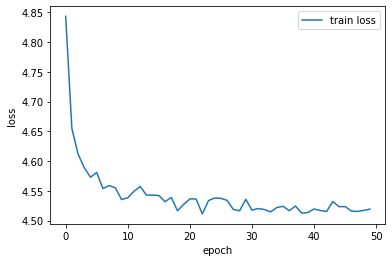

[I 2022-10-18 09:16:32,593] Trial 0 finished with value: 0.07221118360757828 and parameters: {'n_layer': 5, 'kernel_size': 5, 'lr': 0.1, 'epoch_num': 50}. Best is trial 0 with value: 0.07221118360757828.


[tensor(0.0718), tensor(0.0724), tensor(0.0723), tensor(0.0736), tensor(0.0710)]
0.00087189826
1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


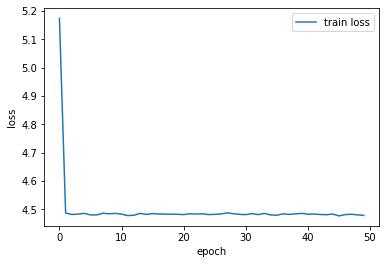

1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


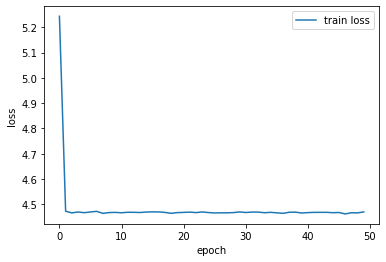

1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


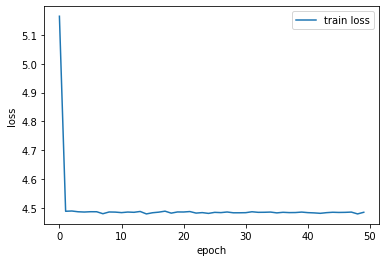

1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


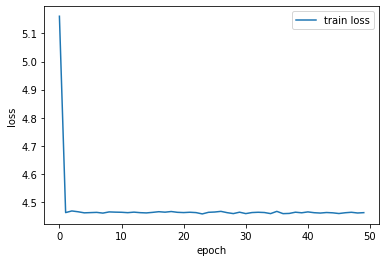

1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:


In [ ]:
# main function
if __name__ == '__main__':
    CUDA_LAUNCH_BLOCKING=1
    root_path = r'/content/drive/Shareddrives/760/Data/'
    train_data_file=r'/content/drive/Shareddrives/760/Data/trainLinearAll.txt'
    #test_data_file=r'/content/drive/Shareddrives/760/Data/testopt.txt'
    batch_size=64
    device = torch.device("cuda:0")
    
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
    study.optimize(objective_cv, n_trials=2)

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

n_layer: 4
kernel_size: 5
lr: 0.1
epoch_num: 10


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
dataset=ClassifyDataset(r'/content/drive/Shareddrives/760/Data/', r'/content/drive/Shareddrives/760/Data/trainLinearCopy.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
loader = torch.utils.data.DataLoader(
            dataset,
            64,
            shuffle=True,
            num_workers=0
        )

In [ ]:
len(dataset)


28

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()


606

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'